# Adversarial Search: Playing Connect 4

Student Name: Chuanqi Deng

I have used the following AI tools: ChatGPT

I understand that my submission needs to be my own work: CD

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

* Initial state:  Empty 6*7 board
* Actions: Drop a disc into a column which is not full.
* Transition model (result function):  s' = result(a, s). When a player drops a disc into a column, it falls to the lowest available position in that column. If the column is full, the player cannot drop a disc into it, and they must choose a different column.
* Goal state (terminal state and utility): A player's 4 discs formed a horizontal, vertical, or diagonal line. A win has a utility of 1, a loss has a utility of -1, and a draw has a utility of 0.

How big is the state space? Give an estimate and explain it.

For each cell on the game board, there are 3 possibilities: empty, filled with a disc from Player 1, or filled with a disc from Player 2.\
So, for each column, there are 3^6 possible combinations (including the possibility of all cells being empty).\
Since there are 7 columns, we multiply 3^6 by itself 7 times to get the total number of possible game states.\
Therefore, the state space is 3^(6*7) = 3^42.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

At the first level of the tree (initial state), there are 7 possible moves.\
At the second level, assuming all columns are available, there are 6 possible moves for the opponent (one less because the column chosen by the first player is now unavailable).\
At the third level, there are again 7 possible moves for the first player.\
This pattern continues, alternating between 7 and 6 possible moves at each level until the game ends or reaches a terminal state.\
The average branching factor can be estimated as the average of 7 and 6, which is approximately 6.5.\

The maximum number of moves until the game ends is 42 (6 rows x 7 columns).
Using the average branching factor and the depth of 42 moves, we can estimate the size of the game tree as approximately 6.5^42.
Minimax search traverses the complete game tree.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [13]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

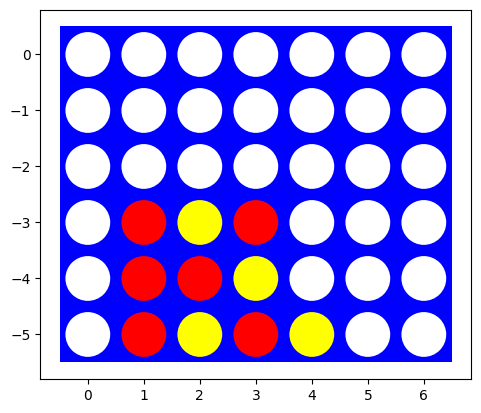

In [14]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 1, -1, 1, 0, 0, 0],
         [0, 1, 1, -1, 0, 0, 0],
         [0, 1,-1, 1, -1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [23]:
# Your code/ answer goes here.
def actions(s):
    """return non-full column index """
    NUM_COL = len(s[0])
    s_np = np.array(s)
    
    ret = []
    for col in range(NUM_COL):
        num_empty = len(np.where(s_np[:, col] == 0)[0])
        if num_empty > 0:
            ret.append(col)
    
    return ret
    
    
def result(s, a, player = 1):
    """return state based on given action"""
    s_np = np.array(s)
    NUM_ROW = len(s)
    for row in range(NUM_ROW-1, -1, -1):
        if s_np[row][a] == 0:
            s_np[row][a] = player
            break
            
    return s_np

def four_connected(l):
    """check if four same discs connected horizontally, vertically, or diagonally."""
    cnt = 0
    player = 0
    for i in l:
        if i == 0:
            cnt = 0
            player = 0
        elif i == player:
            cnt += 1
        else:
            player = i
            cnt = 1

        if cnt == 4:
            return player
    return 0

def check_diagnals(board):
    """check if there any diagonal is connected"""
    k = 0
    while True:
        diag = np.diag(board, k)
        if len(diag) < 4: break
        ret = four_connected(diag)
        if ret != 0: return ret
        k+=1
        
    k = -1
    while True:
        diag = np.diag(board, k)
        if len(diag) < 4: break
        ret = four_connected(diag)
        if ret != 0: return ret
        k-=1
    return 0

def terminal(s):
    """check if s is terminal state"""
    s_np_t = np.transpose(s)
    s_np_flip = np.fliplr(s)

    NUM_ROW = len(s)
    for row in range(NUM_ROW):
        ret = four_connected(s[row])
        if ret != 0: return True
        
    NUM_ROW = s_np_t.shape[0]
    for row in range(NUM_ROW):
        ret = four_connected(s_np_t[row])
        if ret != 0: return True
    
    if check_diagnals(s) != 0: return True
    if check_diagnals(s_np_flip) != 0: return True

    if len(np.where(np.array(s) == 0)[0]) == 0:
        return True # 'draw'
    
    return False
    
def utility(s):
    """return the uility of the board"""
    s_np_t = np.transpose(s)
    s_np_flip = np.fliplr(s)

    NUM_ROW = len(s)
    for row in range(NUM_ROW):
        ret = four_connected(s[row])
        if ret != 0: return ret
        
    NUM_ROW = s_np_t.shape[0]
    for row in range(NUM_ROW):
        ret = four_connected(s_np_t[row])
        if ret != 0: return ret
    
    ret = check_diagnals(s)
    if ret != 0: return ret
    ret = check_diagnals(s_np_flip)
    if ret != 0: return ret

    if len(np.where(np.array(s) == 0)[0]) == 0:
        return 0
    
    raise Exception('Not in terminal state')

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [16]:
# Your code/ answer goes here.
def random_player(board, player = 1):
    return np.random.choice(actions(board))

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [30]:
# Your code/ answer goes here.
def switch_player(player, player1, palyer2):
    if player == 1:
        return -1, palyer2
    else:
        return 1, player1

def play(player1, palyer2, N = 1000):
    """Let two agents play each other N times. 1 starts. player1 and palyer2 are agent functions that 
    get the board as the percept and return their next action."""
    results = {1: 0, -1: 0, 0: 0}
    
    for _ in range(N):
        board = empty_board()
        player, fun = 1, player1
        
        while not terminal(board):
            a = fun(board, player)
            board = result(board, a, player)
            player, fun = switch_player(player, player1, palyer2)   
            
        win = utility(board)   # returns the 'n' if the game is not done.
        results[win] += 1

    return results

play(random_player, random_player)

{1: 545, -1: 454, 0: 1}

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [ ]:
# Your code/ answer goes here.
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def minimax_search(board, player = 'x'):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    value, move = max_value(board, player)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
 
    return { "move": move, "value": value}

def max_value(state, player):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state if it is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print("max in: " + str(state) + str([v]) ) 
    if v is not None: return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, return move with the largest value
    for a in actions(state):
        v2, a2 = min_value(result(state, player, a), player)
        if v2 > v:
            v, move = v2, a
    
    if DEBUG >= 2: print("max out: " + str(state) + str([v, move]) ) 
    return v, move

def min_value(state, player):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state if it is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print("min in: " + str(state) + str([v]) ) 
    if v is not None: return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value(result(state, other(player), a), player)
        if v2 < v:
            v, move = v2, a
    
    if DEBUG >= 2: print("min out: " + str(state) + str([v, move]) ) 
    return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [ ]:
# Your code/ answer goes here.

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.

### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [ ]:
# Your code/ answer goes here.

### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [ ]:
# Your code/ answer goes here.